# Train a despeckling neural network

## Introduction
Confocal microscopes can operate in two modes which highlight different microscopic structures
in the tissue, reflectance and fluorescence.  
Reflectance signals are contaminated by multiplicative noise known
as speckle. Speckle is caused by the constructive
and destructive interference of the coherent returns
scattered by small reflectors within each resolution
cell.  
Assuming that the reflectance image is an average of L looks,
the observed SAR image $Y$ is related to the noise free image
$X$ by the following multiplicative model:  
$$ Y = F \odot X $$
$F$ is the speckle noise random
variable and $\odot$ denotes the element-wise multiplication.  
One
common assumption on F is that it follows a Gamma distribution
with unit mean and variance 1
L and has the following probability density function:  
$$ p(F) = \frac{1}{\Gamma (L)} L^L F^{L-1} e^{-LF} $$

![Fluorescence](F.jpg)  
Fluorescende mode.
![Reflectance](R.jpg)  
Reflectance mode.

Our goal here is to reduce the speckle noise artifacts by means of a convolutional neural network.  
To train our model we need a noisy input and a clean target.
We will be using artificially contaminated fluorescence images to do so.

## Experiment

### Preparation

In [1]:
PATH = '/Users/sergio/tfg'
BATCH_SIZE = 4
EPOCHS = 2

In [2]:
import os.path
import sys
sys.path.append(PATH)

In [3]:
DATA_ROOT = os.path.join(PATH, 'crops')

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn import MSELoss, L1Loss
from torch.optim import Adam
import numpy as np
from skimage.measure import compare_ssim as ssim
import tqdm
%matplotlib notebook
import matplotlib.pyplot as plt

from datasets import NoisyScansDataset
from despeckling import models

Defining the following variables will help us make our code device-agnostic

In [5]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda") if cuda else torch.device("cpu")

Let's define some helper functions

In [6]:
# this function returns a dictionary we can use to create our noisy dataset.
def get_noise_args(noise_type):
    if noise_type == 'gaussian':
        return {'random_variable': np.random.normal,
                      'loc': 1, 'scale': 0.1}
    elif noise_type == 'gamma':
        return {'random_variable': np.random.gamma,
                      'shape': 1, 'scale': 1}

In [7]:
# this function computes the sum of SSIM over a batch of images.
def compute_ssim(noisy_batch, clean_batch, median_filter=False):
    # iterate over batch to compute SSIM
    ssim_sum = 0
    for noisy, clean in zip(noisy_batch[:, 0], clean_batch[:, 0]):
        noisy = noisy.data.cpu().numpy()

        if median_filter:
            noisy = (noisy + 1) / 2 * 255
            noisy = noisy.astype(np.uint8)
            noisy = np.median(noisy)
            noisy = (noisy / 255.0 - 0.5) * 2

        ssim_sum += ssim(noisy, clean.data.cpu().numpy(), data_range=2)
    return ssim_sum

In [8]:
# this function returns a torch model based on an easy name
def get_model(model_str, num_layers):
    if model_str == 'log_add':
        return models.LogAddDespeckle(num_layers)
    elif model_str == 'log_subtract':
        return models.LogSubtractDespeckle(num_layers)
    elif model_str == 'multiply':
        return models.MultiplyDespeckle(num_layers)
    elif model_str == 'divide':
        return models.DivideDespeckle(num_layers)
    else:
        raise NotImplementedError(model_str + 'model does not exist.')

In [9]:
# this function returns a pytorch loss object based on a easy name
def get_criterion(criterion_str):
    if criterion_str == 'mse':
        return MSELoss()
    elif criterion_str == 'l1':
        return L1Loss()

### Define the dataset

The dataset returns a pair of images: a multiplicative-noise contaminated image and its corresponding clean image.

We do a 90/10 train/validation split and contaminate the images with a gamma-distributed noise

In [10]:
# dataset returns (noisy, clean) tuple
dataset = NoisyScansDataset(DATA_ROOT, 'F', get_noise_args('gamma'))
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

### Define loss function

Our loss functions will consist on a distance between the output of the model and the clean image.  
L1 (manhattan) or MSE (euclidian) are basic distance measures.

Let's try with MSE

In [11]:
criterion = get_criterion('mse')

### Define despeckling network

Our model consists on a series of convolutional layers followed by a skip connection connected to the input.

* We can transform our input image to the logarithm space (so the noise becomes and additive one) and use a additive skip connection to remove the log noise, then "come back" to linear space.
* Or use a multiplicative or division connection and work directly with the original space.

Every convolutional layer is followed by a batch normalization step and a parametric linear rectified unit (PReLU) activation function. The skip connection is followed by a sigmoid activation to make sure the output is between 0 and 1.  
![Architecture](architecture.png)

Let's try with a divide connection with just 2 convolutional layers

In [12]:
model = get_model('divide', 2)

In [13]:
if cuda:
    model = model.cuda()
    criterion = criterion.cuda()

### Define Adam optimizer.

In [14]:
optimizer = Adam(params=model.parameters(), lr=1e-3)

### Traing loop

<IPython.core.display.Javascript object>


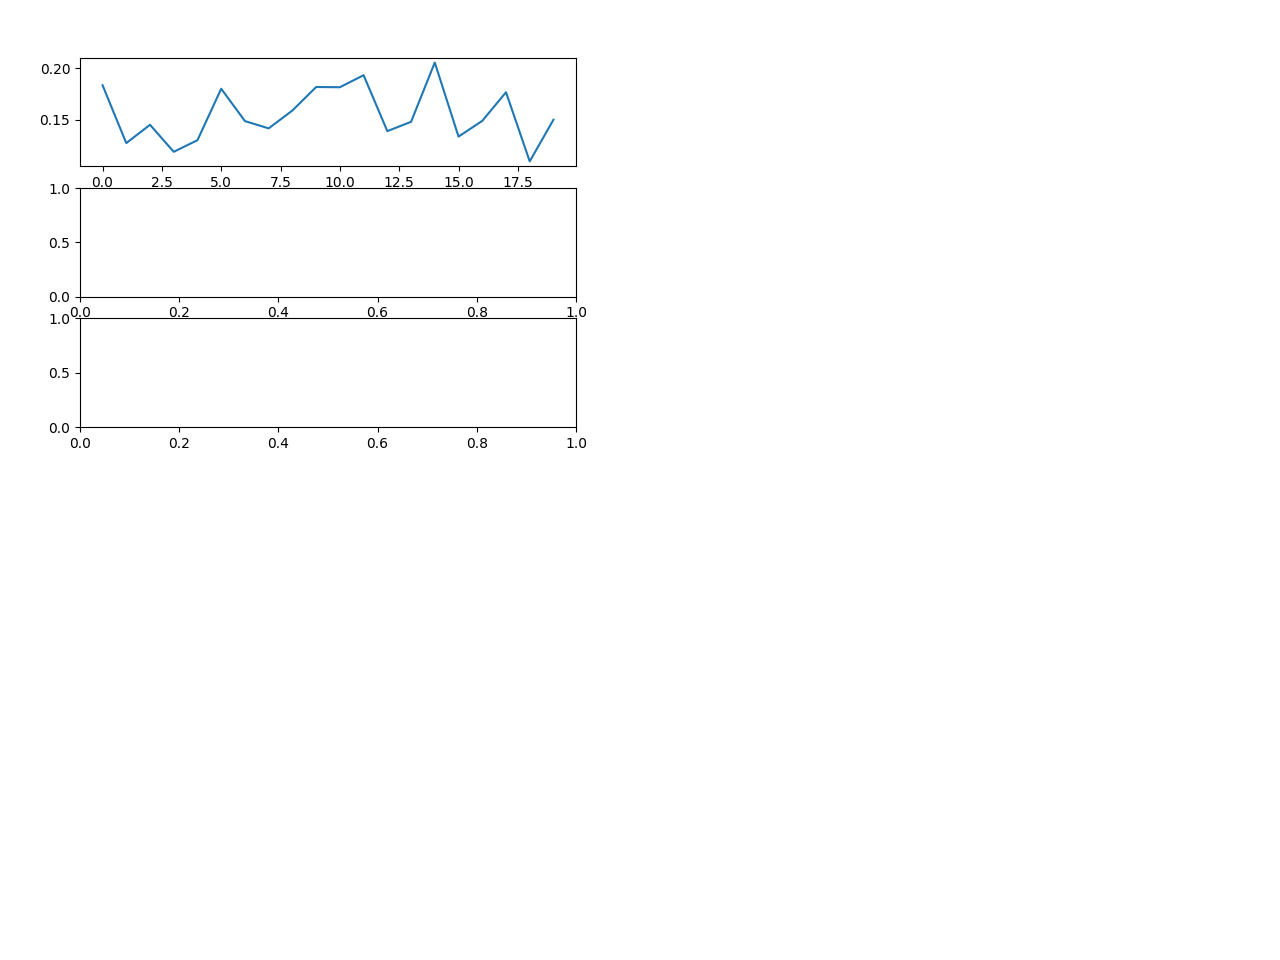

Epoch 0 of 1


Train loss = 0.150:  16%|█▌        | 20/129 [24:51<1:36:48, 53.29s/it]

KeyboardInterrupt: 

In [15]:
# live loss plots
fig = plt.figure()
train_loss_plt = fig.add_subplot(311)
val_loss_plt = fig.add_subplot(312)
ssims_plt = fig.add_subplot(313)
plt.ion()

fig.show()
fig.canvas.draw()

train_loss = []
val_loss = []
ssim_input = []
ssim_output = []

for epoch in range(EPOCHS):
    # TRAINING.
    model.train()

    print('Epoch {} of {}'.format(epoch, EPOCHS - 1))
    input_and_target = tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader))

    for i, (x_batch, target_batch) in input_and_target:
        x_batch, target_batch = x_batch.float().to(device), target_batch.float().to(device)

        optimizer.zero_grad()
        output_batch = model(x_batch)

        loss = criterion(output_batch, target_batch)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.data.cpu().numpy())

        input_and_target.set_description('Train loss = {0:.3f}'.format(loss))
        # plotting
        train_loss_plt.clear()
        train_loss_plt.plot(train_loss)
        fig.canvas.draw()

    # VALIDATION.
    print('Validation:')
    model.eval()
    input_and_target = tqdm.tqdm(enumerate(val_dataloader), total=len(val_dataloader))

    med_loss_eval = 0
    prev_loss_eval = 0
    with torch.no_grad():
        for i, (x_batch, target_batch) in input_and_target:
            x_batch, target_batch = x_batch.float().to(device), target_batch.float().to(device)
            output_batch = model(x_batch)
            loss = criterion(output_batch, target_batch)
            med_loss_eval += loss.data.cpu().numpy()
            prev_loss_eval = criterion(x_batch, target_batch).data.cpu().numpy()

            ssim_input.append(compute_ssim(x_batch, target_batch) / BATCH_SIZE)
            ssim_output.append(compute_ssim(output_batch, target_batch) / BATCH_SIZE)
            val_loss.append(loss)

            input_and_target.set_description(
                'Output loss = {0:.3f}'.format(loss)
                + ' Input loss = {0:.3f}'.format(prev_loss_eval)
                + ' Input SSIM = {0:.3f}'.format(ssim_input[-1])
                + ' Output SSIM = {0:.3f}'.format(ssim_output[-1]))
            # plotting
            val_loss_plt.clear()
            val_loss_plt.plot(val_loss)
            fig.canvas.draw()
